# Exploratory Data Analysis with Seattle Housing Data

## Preparations

Lets first import the necessary libraries and load the files needed for our EDA:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import altair as alt
import plotly.io as pio
pio.renderers.default = "notebook"

df = pd.read_csv("data/King_County_House_prices_dataset.csv")

# Load additional Seattle zipcode data
df_dens_source = pd.read_html('http://zipatlas.com/us/wa/zip-code-comparison/population-density.htm')[10]
df_income_source = pd.read_csv("data/income_by_zipcode_WA.csv")
df_income_source[['zip','population']] = df_income_source["Zip / Population"].str.split(" / ",expand=True,)
df_income_source[['sign','median_household_income']] = df_income_source["Median Household Income ▼"].str.split("$",expand=True,)

# Get rid of the warning
pd.options.mode.chained_assignment = None  # default='warn'

## Understanding the Data

In [2]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

As is shown above, there are data on 21597 houses sold in or near Seattle area. Apart from the id field, there are 20 fields that provide information about these houses. Fortunately, the dataset seems to not suffer much from missing values: only 'Waterfront', 'View' and 'yr_renovated' have some null values. The column names are quite well formatted as well. 

### Cleaning the data

The date column is unordered here. Let's sort the dates ascending.

In [4]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(by ='date',ascending=True)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7316,2202500290,2014-05-02,435000.0,4,1.0,1450,8800,1.0,0.0,0.0,...,7,1450,0.0,1954,0.0,98006,47.5746,-122.135,1260,8942
20586,7853361370,2014-05-02,555000.0,4,2.5,3310,6500,2.0,0.0,0.0,...,8,3310,0.0,2012,0.0,98065,47.5150,-121.870,2380,5000
1040,7197300105,2014-05-02,550000.0,4,2.5,1940,10500,1.0,NaN,0.0,...,7,1140,800.0,1976,0.0,98052,47.6830,-122.114,2200,10500
20543,3438501320,2014-05-02,295000.0,2,2.5,1630,1368,2.0,0.0,0.0,...,7,1280,350.0,2009,0.0,98106,47.5489,-122.363,1590,2306
9587,472000620,2014-05-02,790000.0,3,2.5,2600,4750,1.0,0.0,0.0,...,9,1700,900.0,1951,0.0,98117,47.6833,-122.400,2380,4750


## Research Question

### What is the best time (month of year) to buy a middle-priced house in a lively, central neighbourhood?

### 3 Hypotheses:
1. If you buy a house in the cold months, it is cheaper.
2. If you look for the houses more to the east, it is cheaper. 
3. If the house has more bedrooms, the price is higher.

### Segmenting the houses step 1: middle price range

The analysis could be affected by the outliers of very high-priced houses. As the stakeholder is considering "middle price range", it is better to reduce the size of our data frame by limiting a price range.

In [5]:
df.price.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

It is assumed that the middle price range is the houses prices in 25% to 75% percentiles, which between 322000 and 645000 dollars. 

In [6]:
df1 = df[(df['price'] >= 322000) & (df['price'] <= 645000)]

df1.shape


(10832, 21)

Here, the size of the data is reduced to 10832 records.

<AxesSubplot: title={'center': 'Housing price segmented'}>

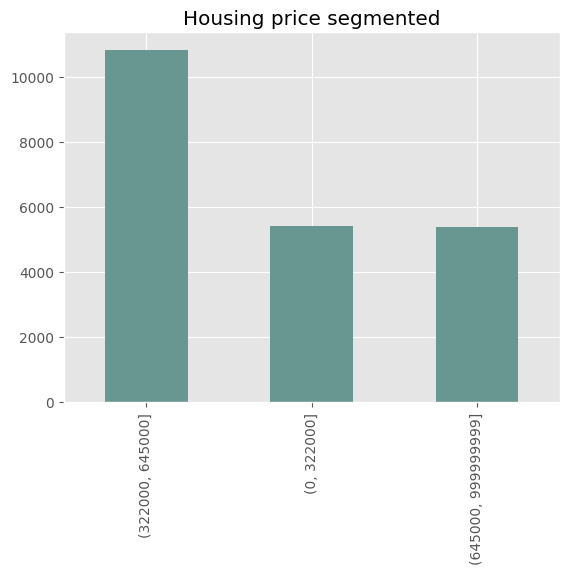

In [41]:
df_price = pd.cut(df.price, bins =[0, 322000, 645000, 999999999])

df_price.value_counts().plot(kind='bar', color="#689691", title="Housing price segmented")

Using this plot, it is illustrated that the upper and lower bar which are both 25% of the dataset were filtered out of the analysis.

### Segmenting the houses step 2: lively neighbourhood

It is assumed that the higher the "sqft_living15" value is, the livelier the neighbourhood. It means that the square footage cof interior housing living space for the nearest 15 neighbors is larger, so probably more people are living in the neighbourhood. 

In [8]:
df.sqft_living15.median()

1840.0

Further filter the data by only looking at the houses that have higher or equal to the median "sqft_living15" value among all houses:

In [9]:
df2 = df1[df1['sqft_living15'] >= 1840]

df2.shape

(5244, 21)

Now the data has been narrowed down to 5244 records.

### Segmenting the houses step 3: central neighbourhood

Here, it is assumed that houses with higher density is more central. The additional density data is imported from http://zipatlas.com/

In [10]:
# List the zip codes with higher density

df_dens_source[1][1:101].unique()
str(df_dens_source[1][1:101].unique()).replace("'", "").replace(" ", ",").replace("\n", "")


'[98174,98121,98104,98101,98102,98122,98105,98107,98103,98119,98109,98403,98117,98144,99204,98116,98118,98115,98112,98125,98136,98133,99207,98146,98408,98559,98126,98204,98405,98406,98007,98337,98043,98023,98444,99205,98902,98199,98198,98106,98155,98178,98402,98201,99201,98008,98031,98034,99203,98002,98465,98404,98467,98664,98056,98026,98683,98033,98037,98407,98466,98225,98661,98040,98003,98020,98036,98684,98166,98028,98168,98006,98011,99202,98235,98663,98177,98499,99336,98004,98409,98203,98498,98208,98148,98385,98108,98503,98310,98353,98052,98422,98934,99001,98354,98012,98270,98055,98311,98665]'

In [11]:
# Get a subset of data frame with only the houses in the higher density zipcode area

df3 = df2.loc[df2['zipcode'].isin([98174,98121,98104,98101,98102,98122,98105,98107,98103,98119,98109,98403,98117,98144,99204,98116,98118,98115,98112,98125,98136,98133,99207,98146,98408,98559,98126,98204,98405,98406,98007,98337,98043,98023,98444,99205,98902,98199,98198,98106,98155,98178,98402,98201,99201,98008,98031,98034,99203,98002,98465,98404,98467,98664,98056,98026,98683,98033,98037,98407,98466,98225,98661,98040,98003,98020,98036,98684,98166,98028,98168,98006,98011,99202,98235,98663,98177,98499,99336,98004,98409,98203,98498,98208,98148,98385,98108,98503,98310,98353,98052,98422,98934,99001,98354,98012,98270,98055,98311,98665])]

df3.shape

(2574, 21)

Now there are only 2574 records that are in the middle price range, more lively and central-located. 

### Segmenting the houses step 4: higher-income neighbourhood

The assumption here is that the live quality is better when you are living in a more well-off neighbourhood. The income by zip code information is imported from [this website](http://www.usa.com/rank/washington-state--median-household-income--zip-code-rank.htm). Here, the data is filtered to top 100 income level zip codes among over 500 zip codes. 

In [12]:
str(df_income_source.zip[1:101].unique()).replace("'", "").replace(" ", ",").replace("\n", "")

'[98039,98314,98075,98074,98077,98040,98065,98053,99154,98006,98296,98072,98033,98052,98027,98112,98004,98029,98024,98014,99005,98110,98021,98333,99023,98038,98059,99338,98019,98117,98177,98275,98008,98115,98028,98042,98045,98012,99036,98005,98164,98136,98332,98199,98607,98280,98345,98391,98422,98327,98058,98109,98034,99353,98272,98685,98020,98051,98642,98335,98258,98103,98374,98606,98290,98360,99025,98380,99352,99128,98007,99323,98011,98232,98119,98208,98538,98629,98026,98367,98116,98292,98205,98070,98121,98001,98056,98155,98686,99019,98321,98649,98092,98107,98010,98375,99026,98370,98385,98950]'

In [13]:
df4 = df3.loc[df3['zipcode'].isin([98039,98314,98075,98074,98077,98040,98065,98053,99154,98006,98296,98072,98033,98052,98027,98112,98004,98029,98024,98014,99005,98110,98021,98333,99023,98038,98059,99338,98019,98117,98177,98275,98008,98115,98028,98042,98045,98012,99036,98005,98164,98136,98332,98199,98607,98280,98345,98391,98422,98327,98058,98109,98034,99353,98272,98685,98020,98051,98642,98335,98258,98103,98374,98606,98290,98360,99025,98380,99352,99128,98007,99323,98011,98232,98119,98208,98538,98629,98026,98367,98116,98292,98205,98070,98121,98001,98056,98155,98686,99019,98321,98649,98092,98107,98010,98375,99026,98370,98385,98950])]
df4.shape

(1644, 21)

Now the focus is on the 1644 properties that are lively and central located, in the middle price range as well as in the higher income level area. 

### Segmenting the houses step 5: quality of living

First of all, to have a good quality housing, the condition of the house should be at least 3.

In [14]:
df5 = df4[(df4['condition'] >= 3)]

The higher the grade is, the better the quality of living there. It is assumed here that this value must be at least 9.

In [15]:
df6 = df5[(df5['grade'] >= 9)]

In [16]:
df6.shape

(155, 21)

Now there are 155 records that match our expectation of the house. This subset of data can be used to make analyses and offer suggestions.

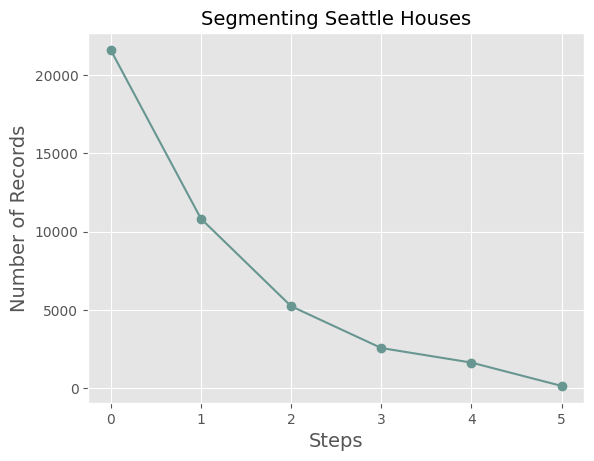

In [34]:
# generate a line chart for each steps

Steps = [0,1,2,3,4,5]
Records = [21597,10832,5244,2574,1644,155]

plt.plot(Steps, Records, color='#689691', marker='o')
plt.title('Segmenting Seattle Houses', fontsize=14)
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Number of Records', fontsize=14)
plt.grid(True)
plt.show()

This chart shows how the number of records go down after each step.

## 1. Best timing of the year

To determine the best timing of the year, a boxplot is used for the price by months for the selected 155 records.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


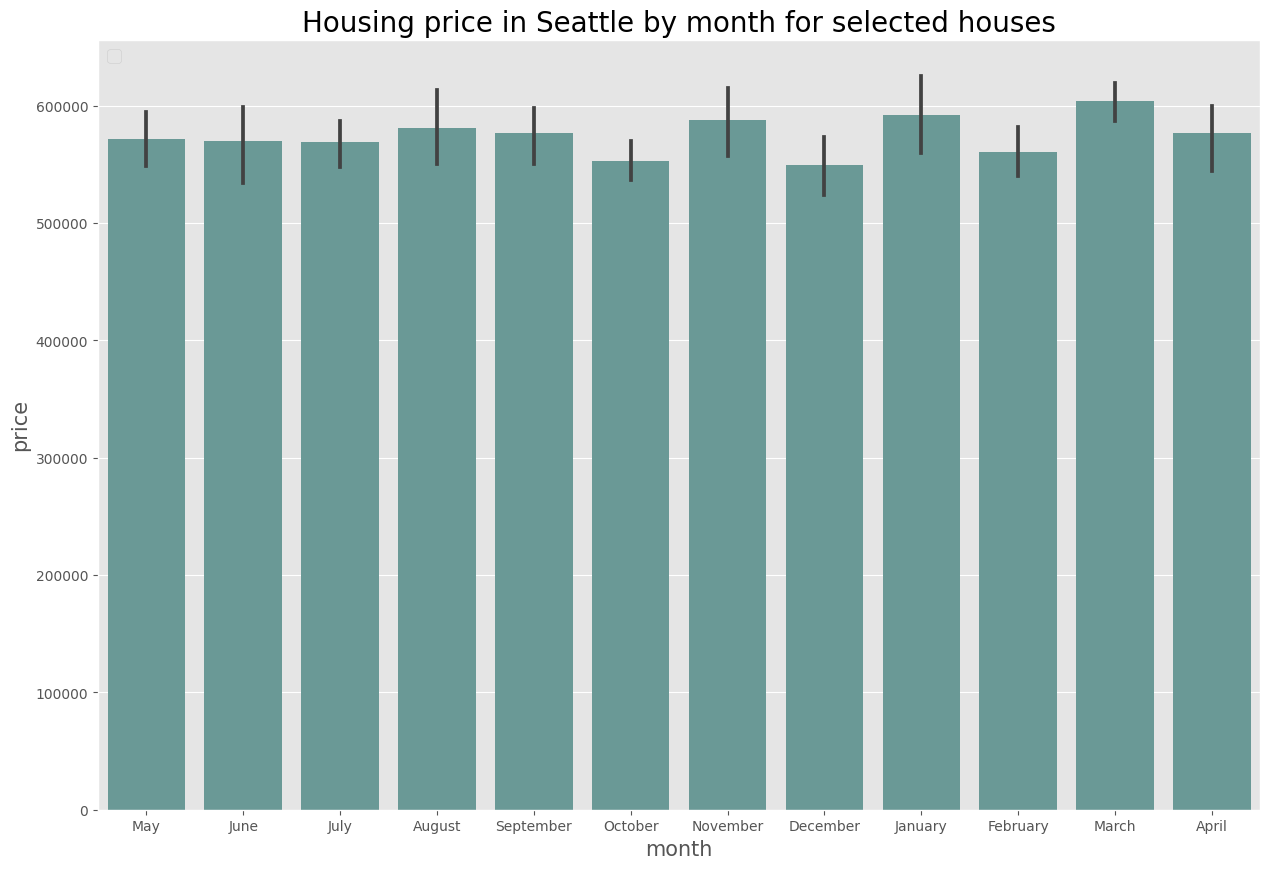

In [45]:
df6['year'] = df6.date.dt.year
df6['month_year'] = df6['date'].dt.strftime('%B')

fig, ax = plt.subplots(figsize=(15,10))

sns.barplot(x=df6.month_year, y=df6.price, data=df6.price, color= "#62A19D")
plt.xlabel('month', fontsize=15)
plt.ylabel('price', fontsize=15)
plt.title('Housing price in Seattle by month for selected houses', fontsize=20)
plt.legend(loc='upper left', fontsize=13)
plt.show()

It can be seen that the month December saw the lowest mean price throughout the year, and it is also the month with the lowest minimum price. Therefore, buying in December stands a good chance for a good deal. October and February would be the next months on the recommendation list, although the price is slightly higher. March, January and November will be the months to avoid as the mean prices are the highest.

## 2. Geolocation

To test the hypothesis if the houses more to the east (inland) will be cheaper, the longitude is used. The larger the longitude, the more the house is located to the east. 

In [18]:
df6_corr = df6.corr()['price']
df6_corr

/var/folders/3d/wt8kbnl925q9rj8rg2653hg40000gn/T/ipykernel_88684/3598449235.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



id               0.005908
price            1.000000
bedrooms         0.114779
bathrooms        0.034831
sqft_living      0.150172
sqft_lot         0.130592
floors          -0.019724
waterfront            NaN
view             0.114980
condition        0.064489
grade            0.037506
sqft_above       0.122362
yr_built        -0.106649
yr_renovated     0.059321
zipcode         -0.058199
lat             -0.030467
long             0.061581
sqft_living15    0.194926
sqft_lot15       0.120921
year             0.100395
Name: price, dtype: float64

Checking the correlation to price for all field, it is shown that latitude has none or very little negative correlation to price and longitude has none or a very weak positive correlation to price.

In [50]:
fig_long = px.scatter(df6, 
           x='long', 
           y='price', 
           size='price', 
           #color='#62A19D',
           title='Housing price in relation to longitude',
           template='ggplot2')
fig_long.show()

Looking at the longitude, west and east end of the graph both have higher prices and it is easier to find lowest priced houses in the middle. 

In [51]:
px.scatter(df6, 
           x='lat', 
           y='price', 
           size='price', 
           title='Housing price in relation to latitude',
           template='ggplot2'
           )

Looking at the latitude, the relation to price is unclear. However, it is easier to find houses below 550K either to the south or to the north, but harder to find in the middle.

More specifically, only a small list of zip codes are left in the recommendation here.

In [21]:
print(df.zipcode.nunique())
print(df6.zipcode.nunique())

70
18


In [22]:
df6.zipcode.unique()

array([98011, 98056, 98052, 98028, 98008, 98155, 98033, 98119, 98034,
       98007, 98199, 98177, 98040, 98006, 98004, 98117, 98136, 98115])

The number of zip codes are narrowed down from 70 in the whole dataset to 18 in the recommended houses.

## 3. Number of bedrooms

The number of bedrooms is an important factor to consider.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


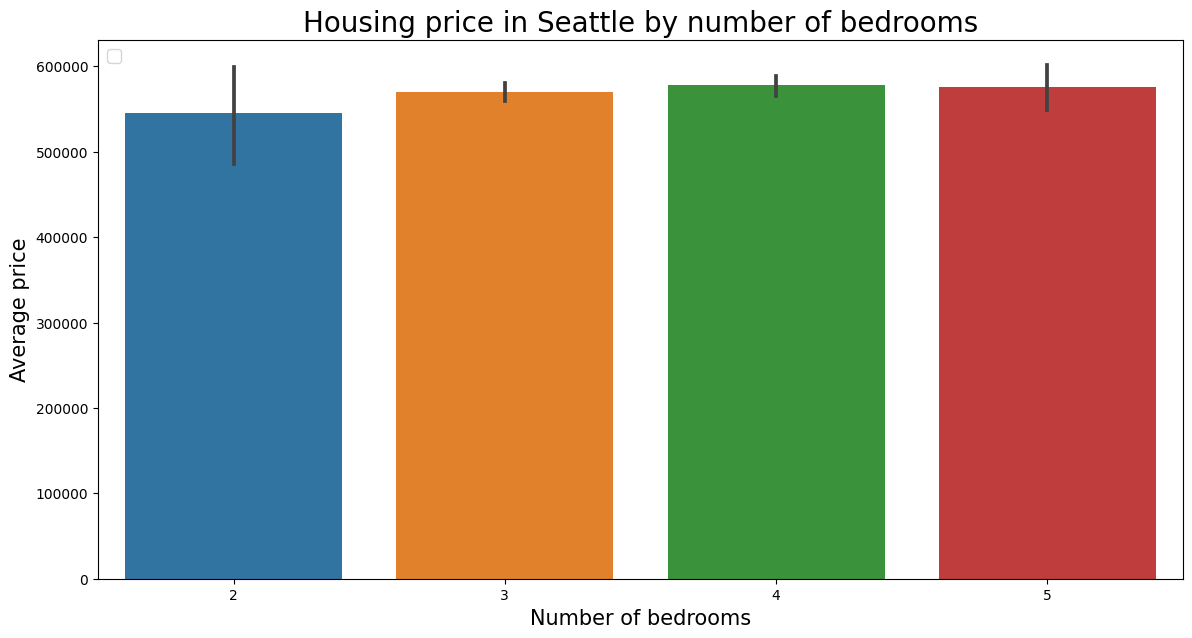

In [23]:
fig, ax = plt.subplots(figsize=(14,7))

sns.barplot(x=df6.bedrooms, y=df6.price, data=df6.price)
plt.xlabel('Number of bedrooms', fontsize=15)
plt.ylabel('Average price', fontsize=15)
plt.title('Housing price in Seattle by number of bedrooms', fontsize=20)
plt.legend(loc='upper left', fontsize=13)
plt.show()

<AxesSubplot: title={'center': 'Number of houses by number of bedrooms'}, xlabel='bedrooms'>

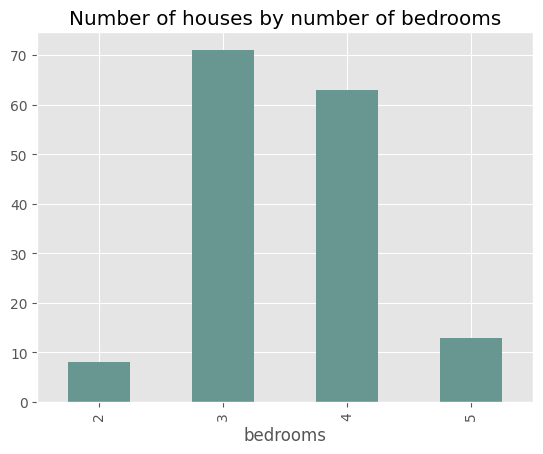

In [72]:
df6.groupby('bedrooms').count()['id'].plot(kind="bar", color="#689691", title="Number of houses by number of bedrooms")

It seems that 3 to 4 bedrooms are the most popular types of houses that are sold. 

For more specific recommendation, the records are further segmented into 2-3 bedrooms and 4-5 bedrooms. The cases where there is only 1 bedroom will be too few bedrooms and more than 5 bedrooms seem to be too many.
To have a high-quality living condition, the house with 2-3 bedrooms must have at least 1 bathroom, and the house with 4-5 bedrooms must have at least 2 bathrooms.

In [73]:
df_less_br = df6[(df6['bedrooms'] >= 2) & (df6['bedrooms'] <= 3)]
df_more_br = df6[(df6['bedrooms'] >= 4) & (df6['bedrooms'] <= 5)]

In [74]:
print(df_less_br.shape)
print(df_more_br.shape)

(79, 23)
(76, 23)


There are 79 records to be references for less bedrooms and 76 records for more bedrooms.

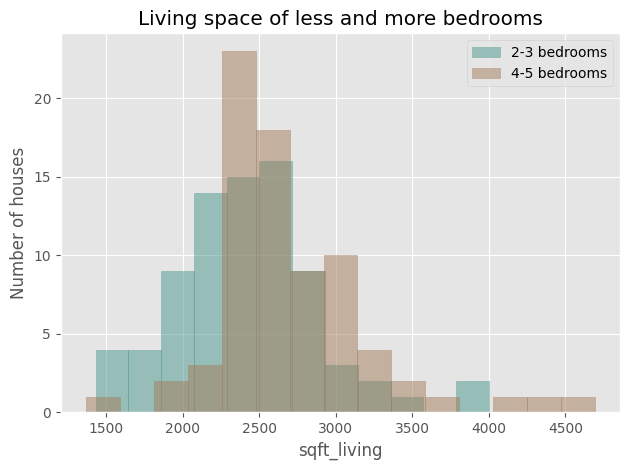

In [75]:
plt.style.use('ggplot')
 
plt.title('Living space of less and more bedrooms')
 
plt.hist(df_less_br['sqft_living'], edgecolor='#4A968D',color='#4A968D',bins=12, alpha=0.5, label='2-3 bedrooms')
plt.hist(df_more_br['sqft_living'], edgecolor='#A37C5A',color='#A37C5A',bins=15, alpha=0.5, label='4-5 bedrooms')
 
plt.legend(loc='upper right')
 
plt.xlabel('sqft_living')
plt.ylabel('Number of houses')
 
plt.tight_layout()
 
plt.show()

Taking a look at the living spaces by less and more bedrooms, it is as expected that less bedrooms have smaller living spaces overall, and more bedrooms houses have bigger living spaces overall.

The mode of 2-3 bedrooms are just above 2500 sqft, whereas mode of 4-5 bedrooms are just below 2500 sqft.

## Plotting maps

In [ ]:
fig = px.scatter_mapbox(df,
                        lat = "lat",
                        lon = "long",
                        zoom = 8,
                        height = 500)
fig.update_layout(mapbox_style = "open-street-map")
fig.show()

In [61]:
fig = px.scatter_mapbox(df6,
                        lat = "lat",
                        lon = "long",
                        zoom = 9,
                        height = 500)
fig.update_layout(mapbox_style = "open-street-map")
fig.show()